<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/%E5%A4%B4%E5%83%8F%E6%BC%AB%E7%94%BB%E9%A3%8E_AnimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn more about AnimeGANv2 here: https://github.com/bryandlee/animegan2-pytorch

In [ ]:
#@title Load Face2Paint model

import torch 
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", device=device).eval()
face2paint = torch.hub.load("bryandlee/animegan2-pytorch:main", "face2paint", device=device)

Downloading: "https://github.com/bryandlee/animegan2-pytorch/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/bryandlee/animegan2-pytorch/raw/main/weights/face_paint_512_v2.pt" to /root/.cache/torch/hub/checkpoints/face_paint_512_v2.pt


  0%|          | 0.00/8.20M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/bryandlee_animegan2-pytorch_main


In [ ]:
#@title Face Detector & FFHQ-style Alignment

# https://github.com/woctezuma/stylegan2-projecting-images

import os
import dlib
import collections
from typing import Union, List
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def get_dlib_face_detector(predictor_path: str = "shape_predictor_68_face_landmarks.dat"):

    if not os.path.isfile(predictor_path):
        model_file = "shape_predictor_68_face_landmarks.dat.bz2"
        os.system(f"wget http://dlib.net/files/{model_file}")
        os.system(f"bzip2 -dk {model_file}")

    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor(predictor_path)

    def detect_face_landmarks(img: Union[Image.Image, np.ndarray]):
        if isinstance(img, Image.Image):
            img = np.array(img)
        faces = []
        dets = detector(img)
        for d in dets:
            shape = shape_predictor(img, d)
            faces.append(np.array([[v.x, v.y] for v in shape.parts()]))
        return faces
    
    return detect_face_landmarks


def display_facial_landmarks(
    img: Image, 
    landmarks: List[np.ndarray],
    fig_size=[15, 15]
):
    plot_style = dict(
        marker='o',
        markersize=4,
        linestyle='-',
        lw=2
    )
    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {
        'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
        'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
        'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
        'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
        'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
        'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
        'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
        'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
        'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
    }

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis('off')

    for face in landmarks:
        for pred_type in pred_types.values():
            ax.plot(
                face[pred_type.slice, 0],
                face[pred_type.slice, 1],
                color=pred_type.color, **plot_style
            )
    plt.show()



# https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

import PIL.Image
import PIL.ImageFile
import numpy as np
import scipy.ndimage


def align_and_crop_face(
    img: Image.Image,
    landmarks: np.ndarray,
    expand: float = 1.0,
    output_size: int = 1024, 
    transform_size: int = 4096,
    enable_padding: bool = True,
):
    # Parse landmarks.
    # pylint: disable=unused-variable
    lm = landmarks
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    x *= expand
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    return img


In [ ]:
# 授权 Colab 访问 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


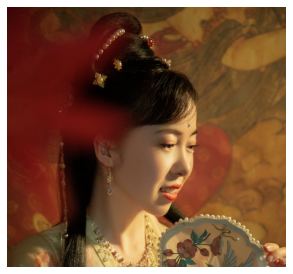

In [ ]:
import requests

#img = Image.open(requests.get("https://upload.wikimedia.org/wikipedia/commons/8/85/Elon_Musk_Royal_Society_%28crop1%29.jpg", stream=True).raw).convert("RGB")
img = Image.open("drive/MyDrive/work/photo/14.png").convert("RGB")

face_detector = get_dlib_face_detector()
landmarks = face_detector(img)

display_facial_landmarks(img, landmarks, fig_size=[5, 5])

for landmark in landmarks:
    face = align_and_crop_face(img, landmark, expand=1.3)
    display(face2paint(model=model, img=face, size=512))